In [1]:
from zipfile import ZipFile
import pandas as pd
from urllib import urlopen
from StringIO import StringIO
import matplotlib.pylab as plt
%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# function used to get a df of data on nypd sqf data
def unzip_read_file(year):
    url = urlopen("http://www.nyc.gov/html/nypd/downloads/zip/analysis_and_planning/{}_sqf_csv.zip".format(year))
    zipfile = ZipFile(StringIO(url.read()))
    try:
        with zipfile.open("{}.csv".format(year)) as file:
            df = pd.read_csv(file)
            
    except: # 2015 csv name is different format than all the rest...go figure.
        with zipfile.open("{}_sqf_csv.csv".format(year)) as file:
            df = pd.read_csv(file)
    return df

# Cleans dates formatted without leading zero for months 1-9
def make_date(date_string):
    if len(date_string)<8:
        date_string = '0'+date_string
    return date_string

In [3]:
d = {'Y': True, 'N': False}
r = {'A': 'ASIAN/PACIFIC ISLANDER', 'B': 'BLACK', 'I': 'AMERICAN INDIAN/ALASKAN NATIVE',
     'P': 'BLACK-HISPANIC', 'Q': 'WHITE-HISPANIC', 'W': 'WHITE', 'U': 'UNKNOWN', 
     'X': 'UNKNOWN', 'Z': 'OTHER'}

In [4]:
df = pd.DataFrame()

In [125]:
try:
    master_df = pd.read_csv('master_df.csv')
except:
    master_df = pd.DataFrame()
    for year in range(2003, 2016):

        year_df = unzip_read_file(year)
        year_df.rename(columns={'adrnum': 'addrnum', 'adrpct': 'addrpct', 'detailcm': 'detailCM', 
                                'dettyp_c': 'dettypCM', 'dettypcm': 'dettypCM', 'linecm': 'lineCM', 
                                'premtyp': 'premtype', 'prenam': 'prename', 'rescod': 'rescode',
                                'stinter': 'strintr', 'stname': 'strname'}, inplace=True)
        if len(list(year_df.columns)) != len(set(list(year_df.columns))):
            print sorted(list(year_df.columns))
        print year

        year_df['datestop'] = year_df['datestop'].astype(str).apply(make_date)
        year_df = year_df[~year_df['datestop'].isin(['0', '0 '])]
        try:
            year_df.datestop = pd.to_datetime(year_df.datestop, format='%m%d%Y')
        except:
            year_df.datestop = pd.to_datetime(year_df.datestop, format='%Y-%m-%d')

        year_df['race'] = year_df['race'].replace(r)
        year_df['arstmade'] = year_df['arstmade'].replace(d)

        table_date = pd.pivot_table(year_df, values='year', index=['pct', 'datestop', 'race'], 
                                    columns='arstmade', aggfunc= 'count')

        table_date.fillna(0, inplace=True)

        table_date['Count'] = table_date[False] + table_date[True]
        table_date['Success_Rate'] = table_date[True] / table_date['Count']



        master_df = master_df.append(table_date)
    
    master_df.to_csv('master_df.csv')
    master_df.reset_index(inplace=True)

In [147]:
master_df = master_df.iloc[:,:5]

#grab the clean data
master_df = master_df[(master_df['datestop'] > '2000-01-01') & (master_df['pct'] != 999) & (master_df['race'] != ' ')]

# Aggregation by date
date_df = master_df.iloc[:,[1,3,4]].groupby('datestop').sum()

# Aggregation by race and date
print master_df.columns[1:5].tolist()
race_date_df = master_df.iloc[:,[1,2,3,4]].groupby(['datestop', 'race']).sum()

# Aggregation by pct and date
print master_df.columns[[0,1,3,4]].tolist()
pct_date_df = master_df.iloc[:,[0,1,3,4]].groupby(['pct', 'datestop']).sum()

# Aggregation by pct
print master_df.columns[[0,3,4]].tolist()
pct_df = master_df.iloc[:,[0,3,4]].groupby('pct').sum()

# Agg. by race
print master_df.columns[2:5].tolist()
race_df = master_df.iloc[:,[2,3,4]].groupby('race').sum()

# Agg. by race and pct
race_pct_df = master_df.iloc[:,[0,2,3,4]].groupby(['race', 'pct']).sum()

['datestop', 'race', 'False', 'True']
['pct', 'datestop', 'False', 'True']
['pct', 'False', 'True']
['race', 'False', 'True']


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

AMERICAN INDIAN/ALASKAN NATIVE
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.029181
SUCCESS_RATE -0.029181      1.000000
WHITE-HISPANIC
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.481047
SUCCESS_RATE -0.481047      1.000000
UNKNOWN
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.065984
SUCCESS_RATE -0.065984      1.000000
ASIAN/PACIFIC ISLANDER
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.124573
SUCCESS_RATE -0.124573      1.000000
BLACK-HISPANIC
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.336612
SUCCESS_RATE -0.336612      1.000000
OTHER
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.212995
SUCCESS_RATE -0.212995      1.000000
BLACK
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.520474
SUCCESS_RATE -0.520474      1.000000
WHITE
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.298553
SUCCESS_RATE -0.298553      1.000000


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

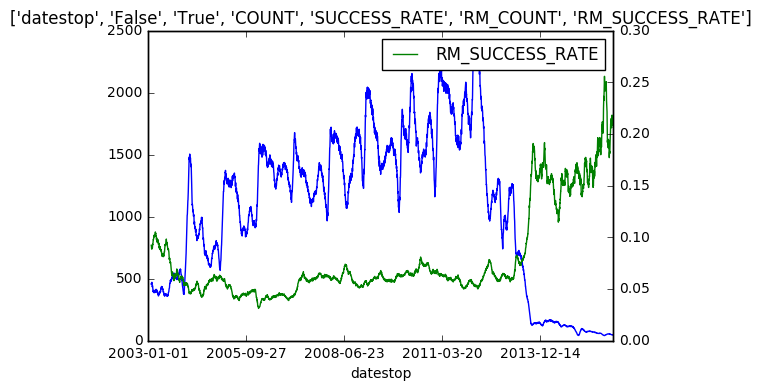

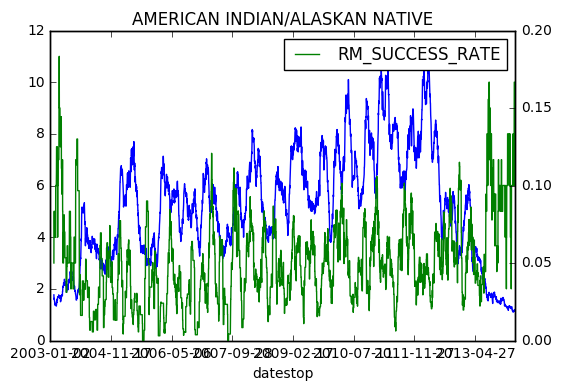

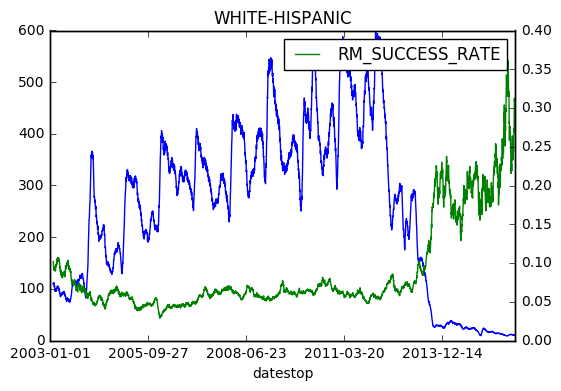

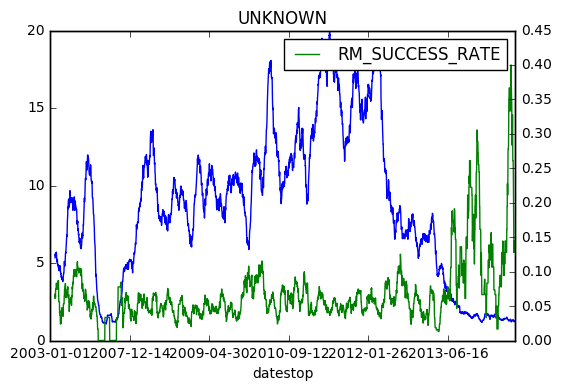

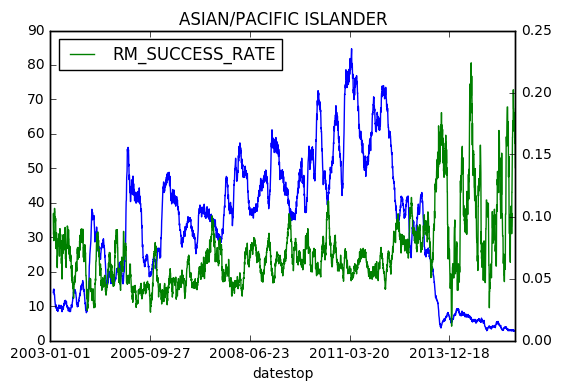

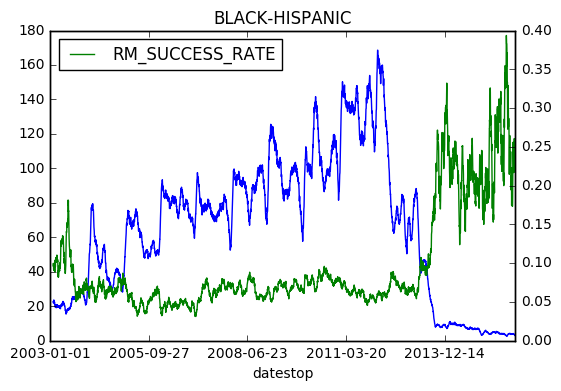

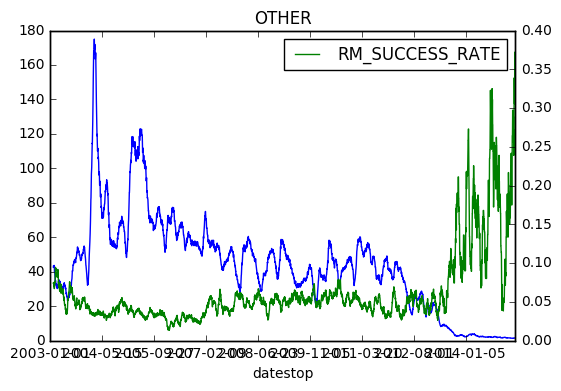

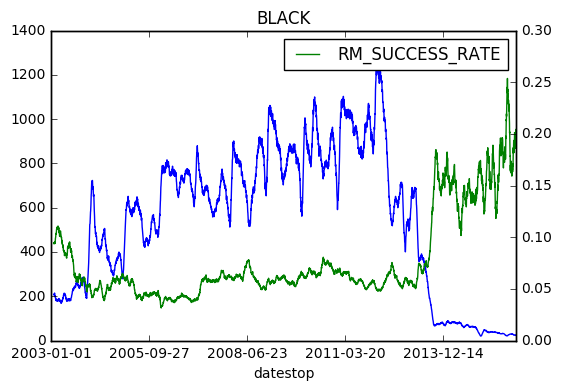

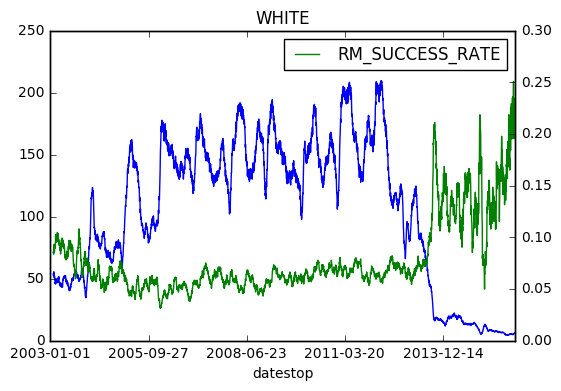

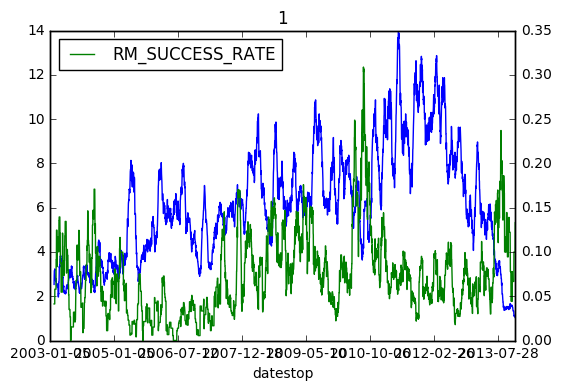

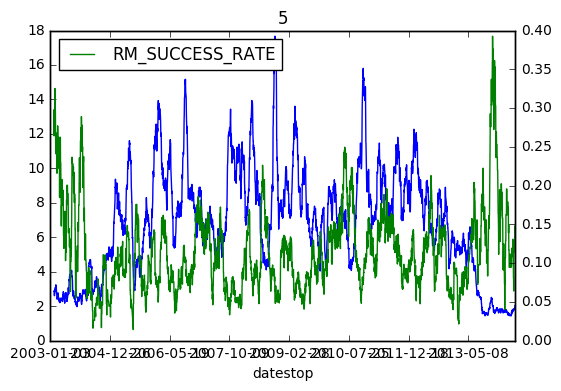

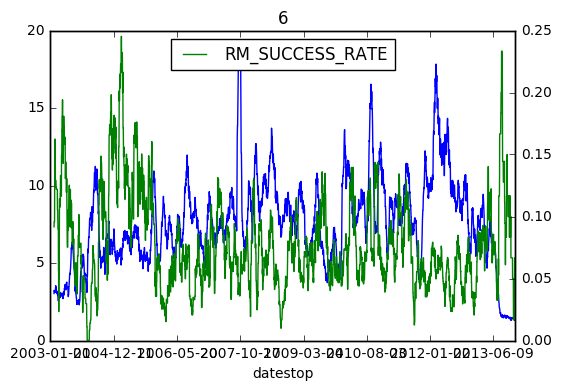

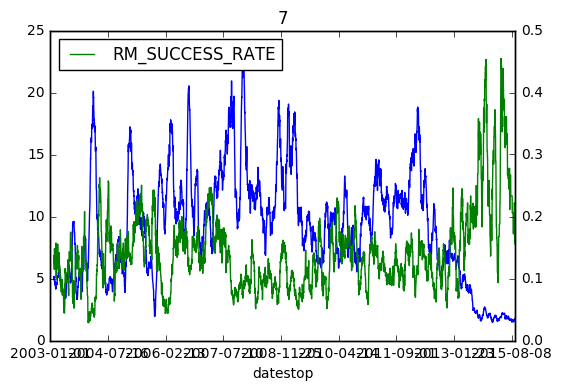

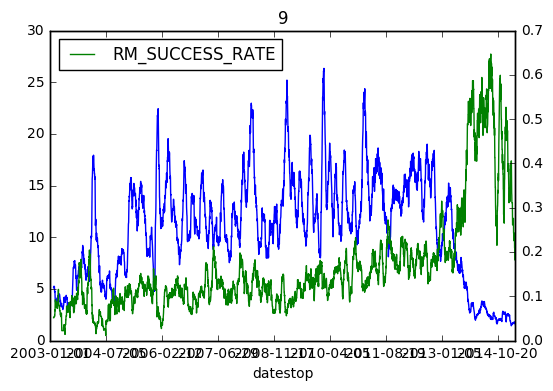

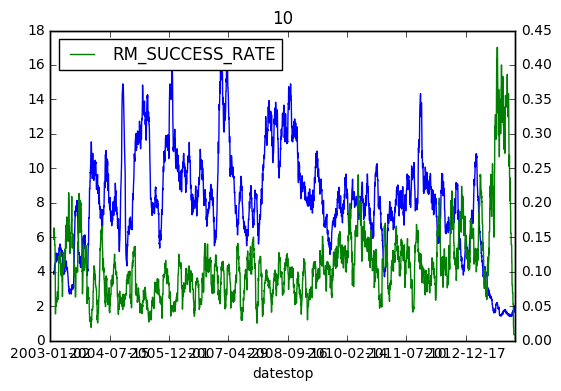

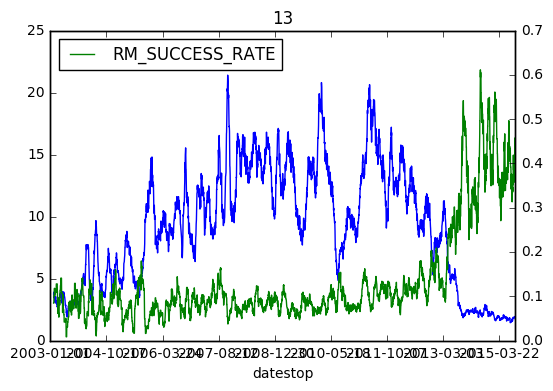

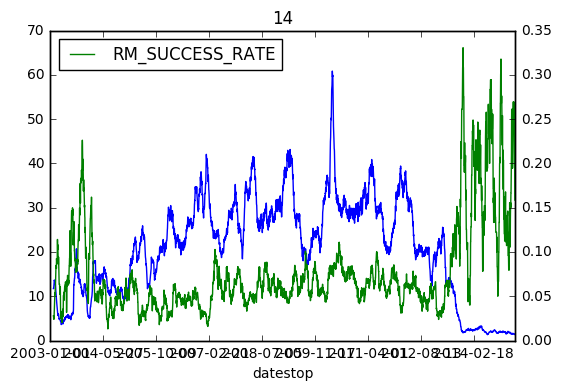

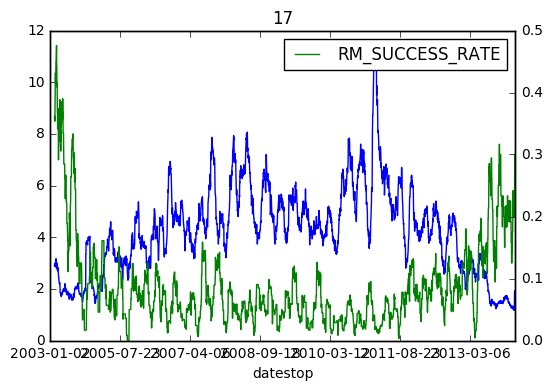

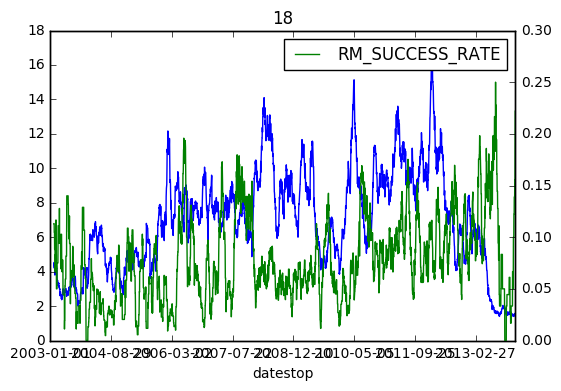

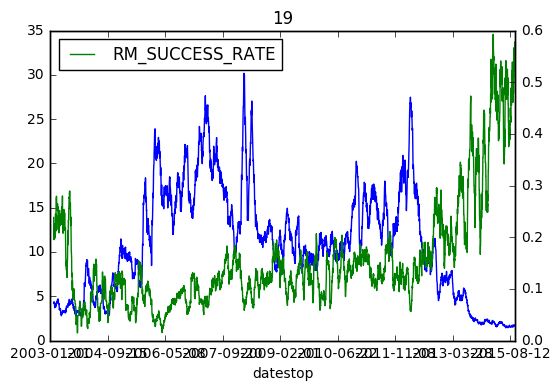

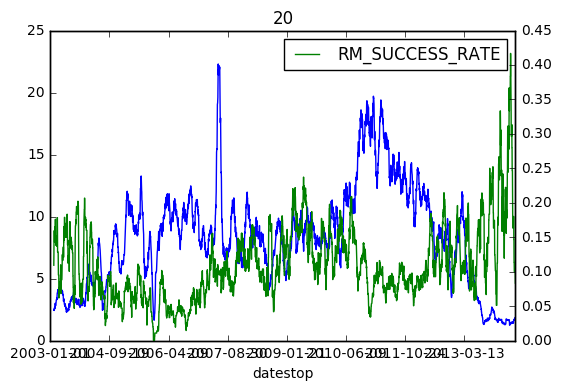

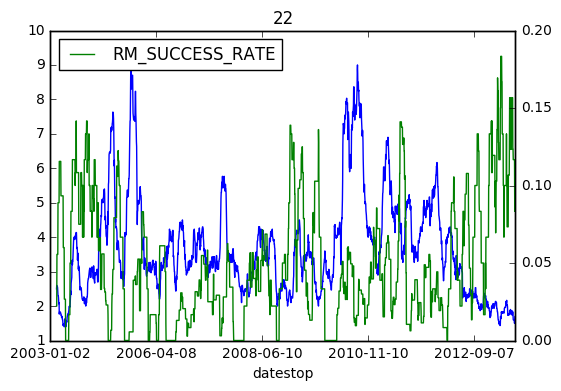

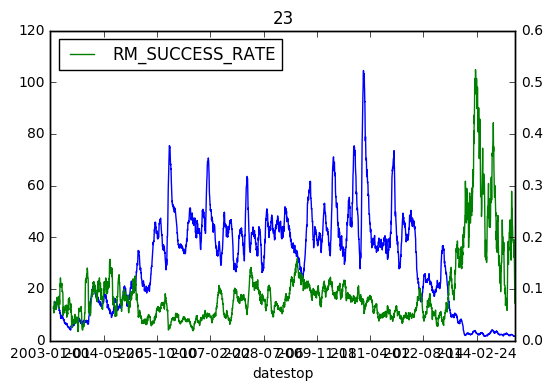

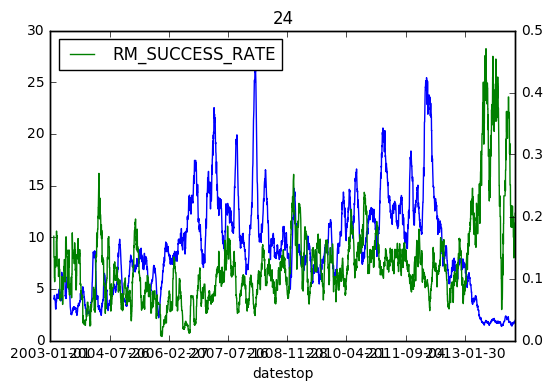

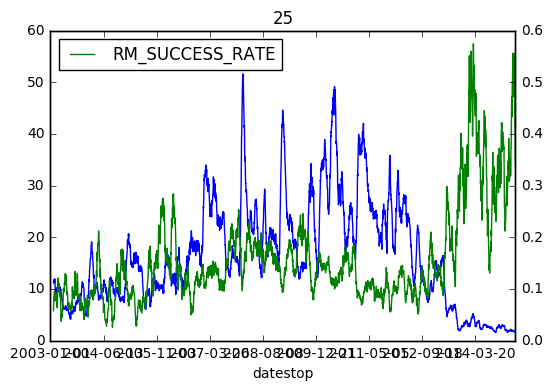

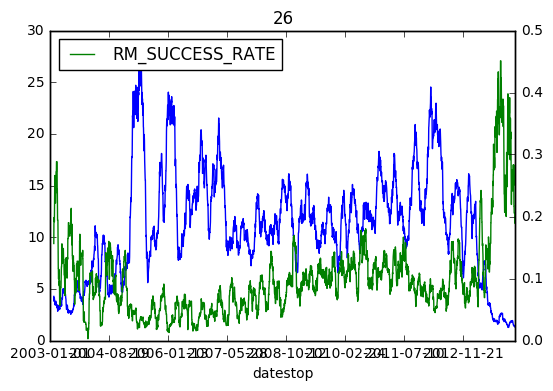

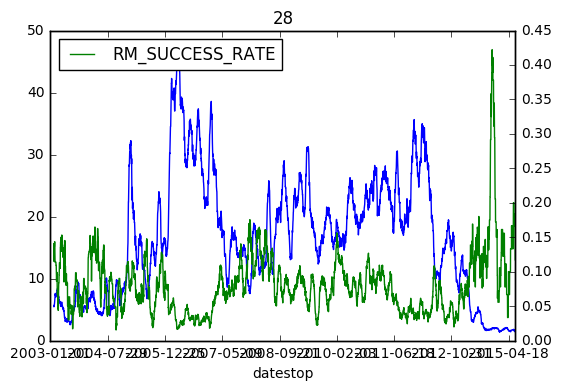

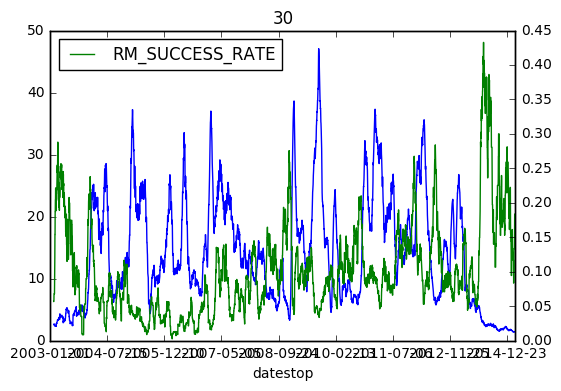

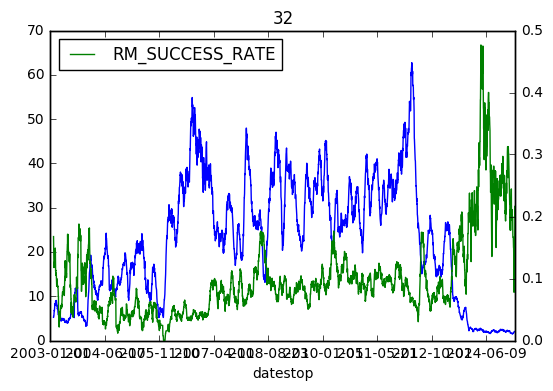

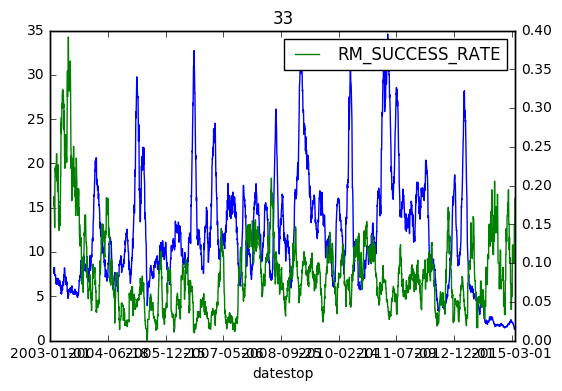

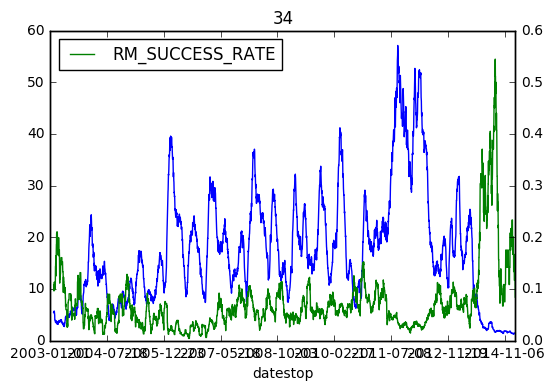

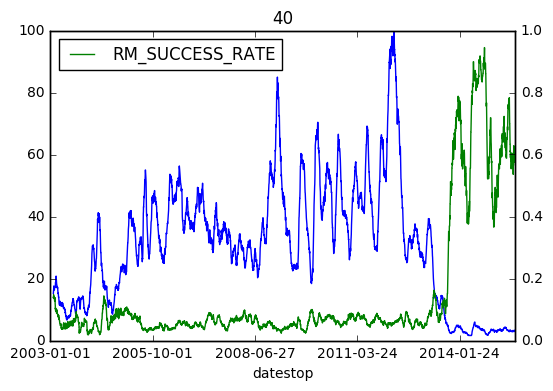

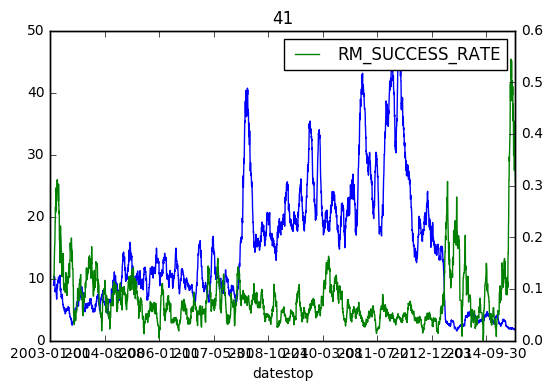

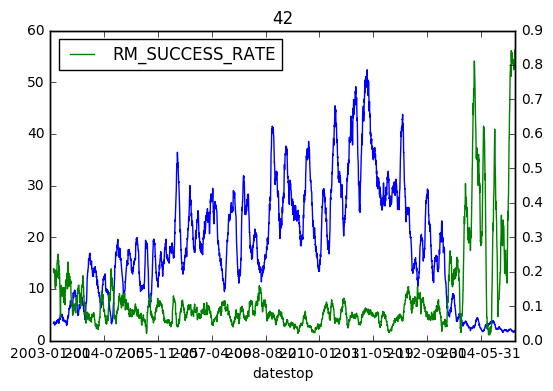

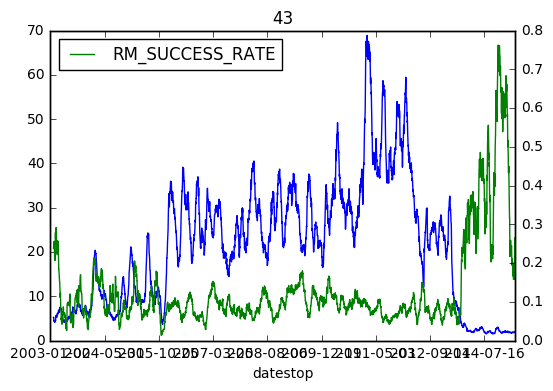

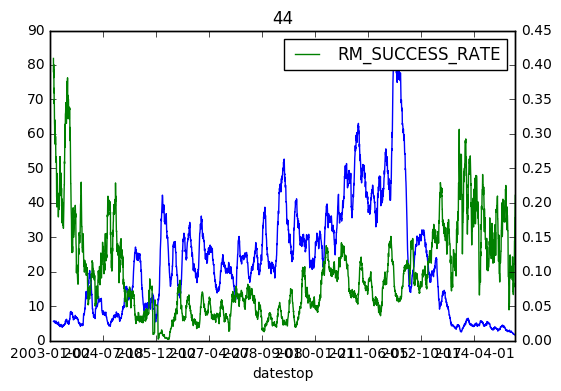

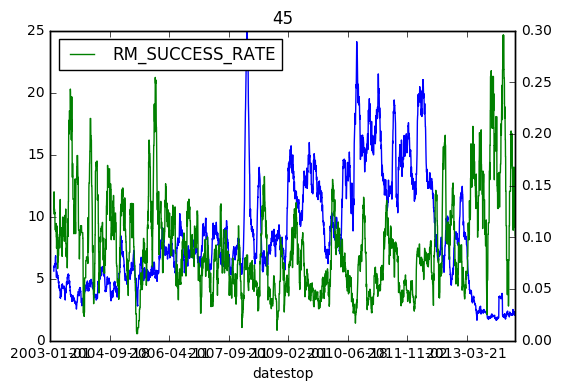

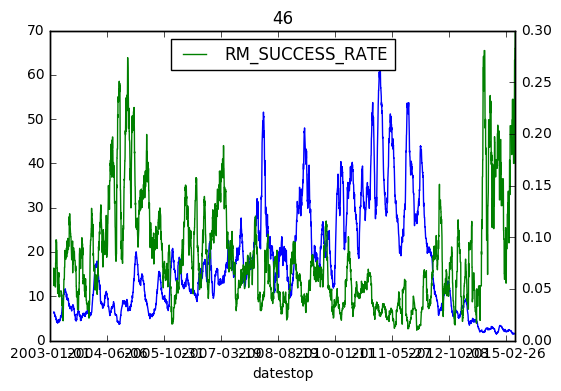

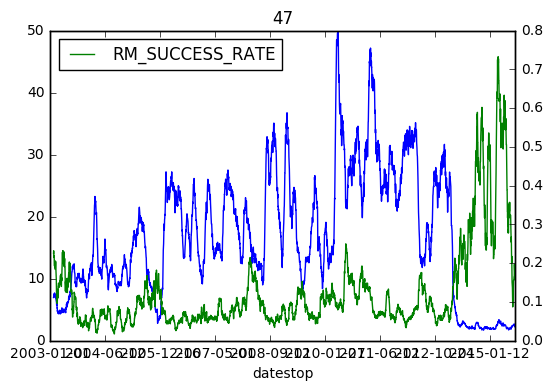

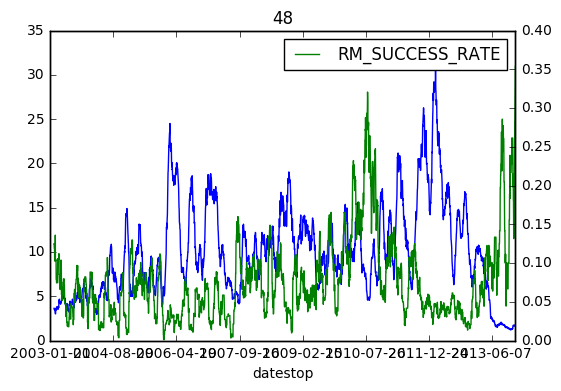

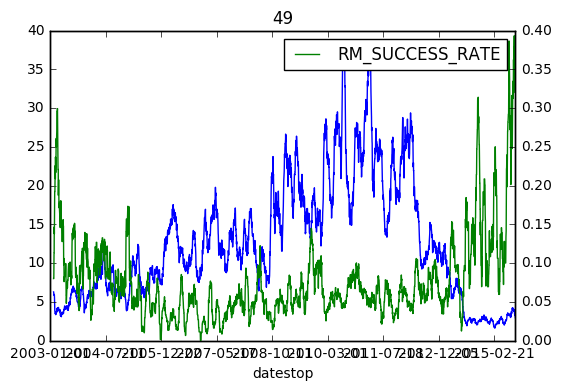

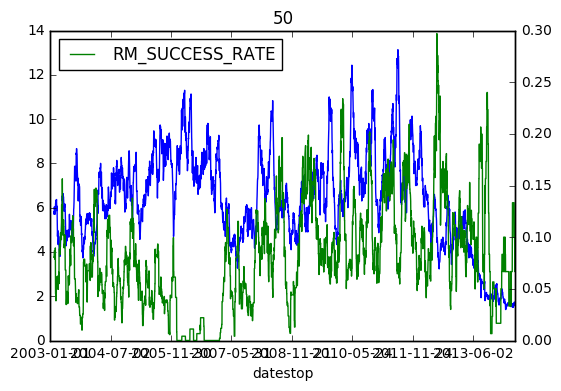

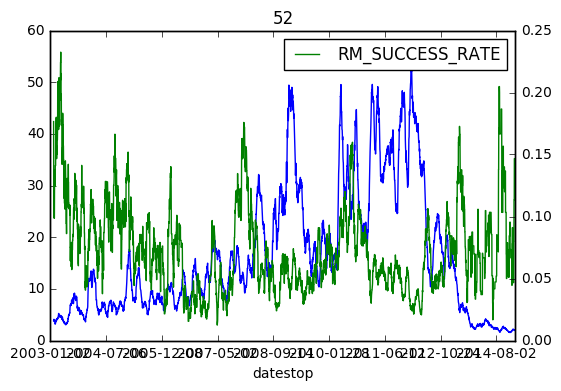

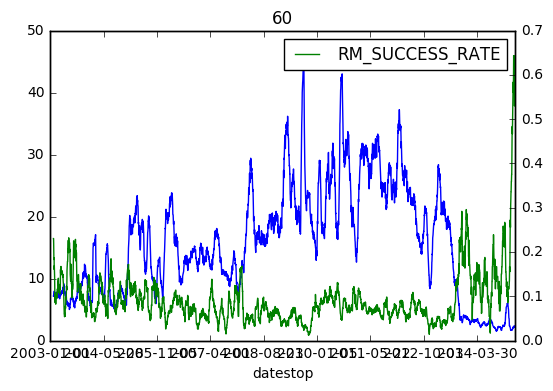

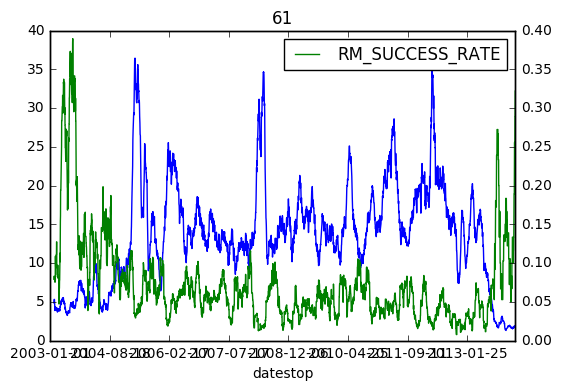

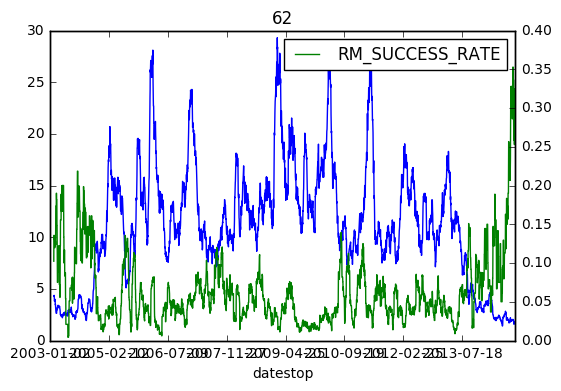

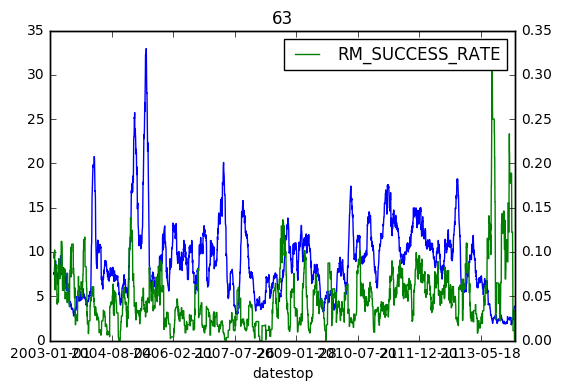

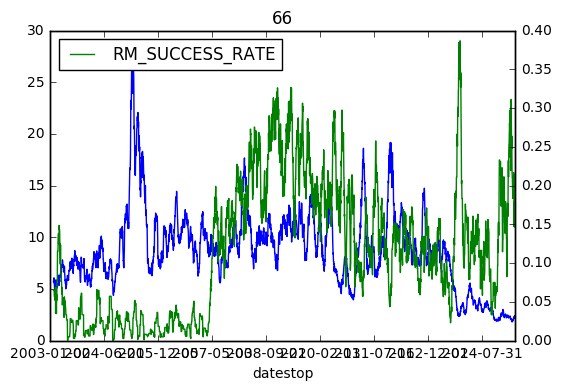

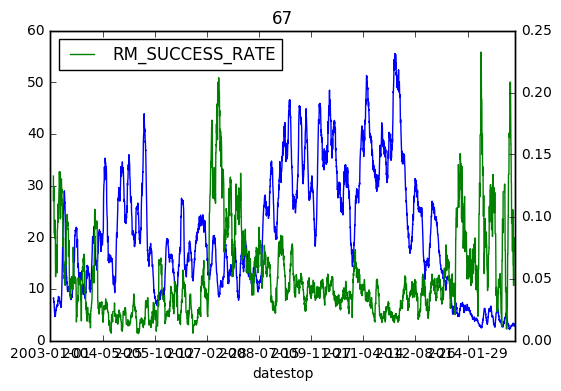

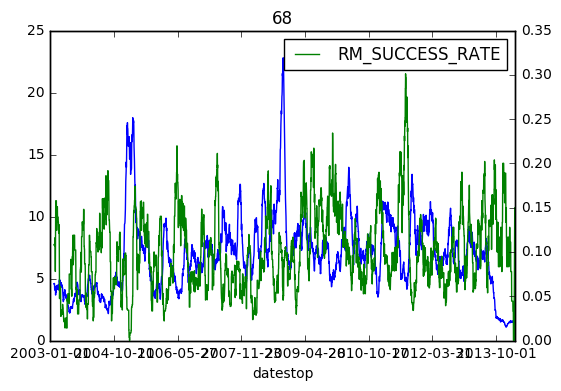

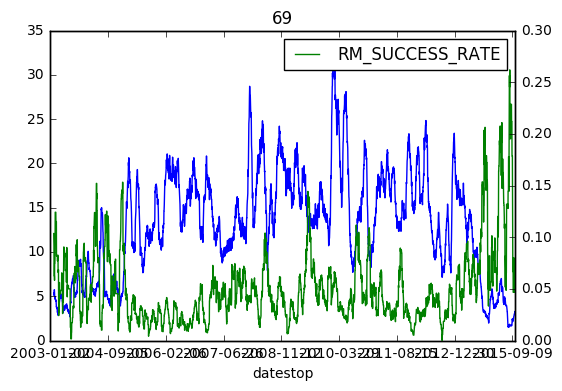

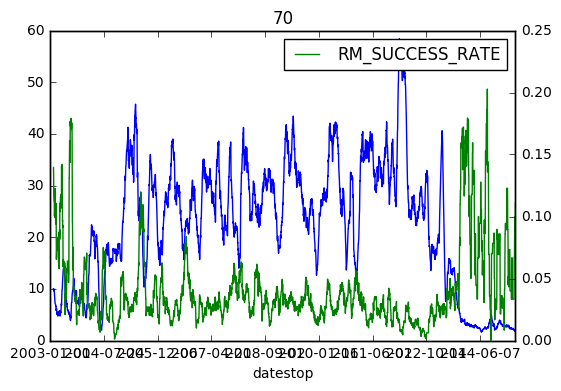

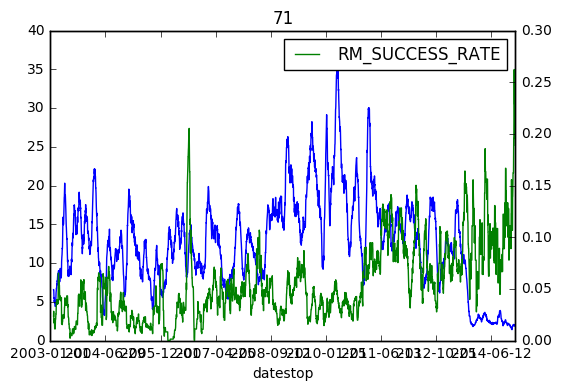

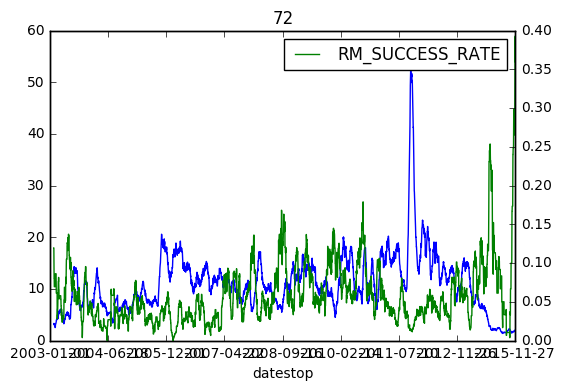

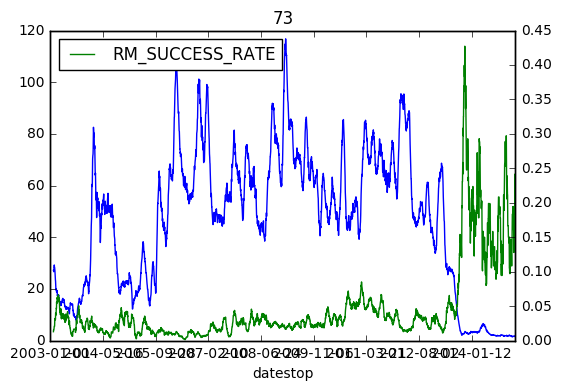

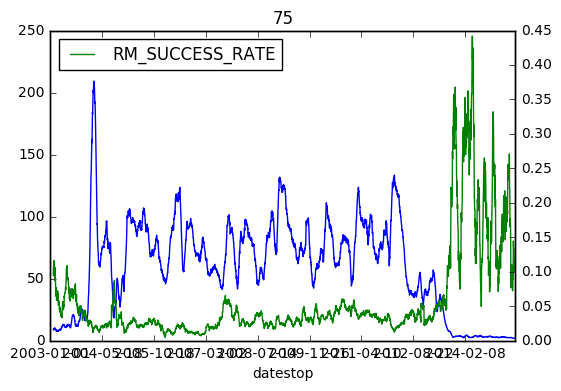

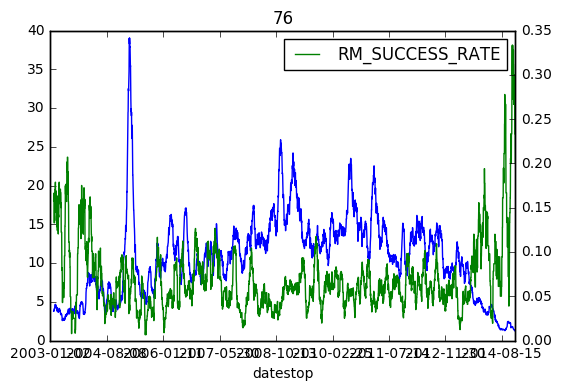

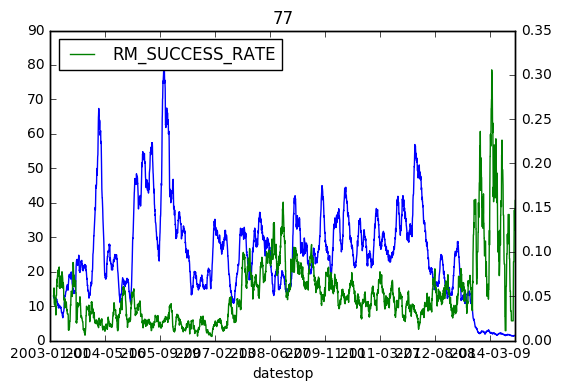

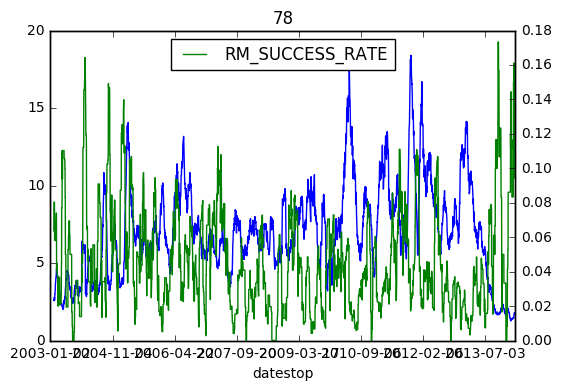

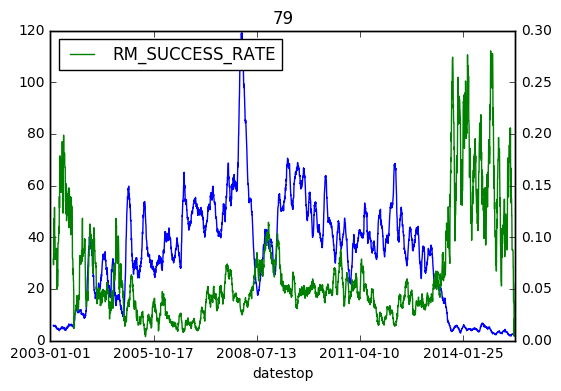

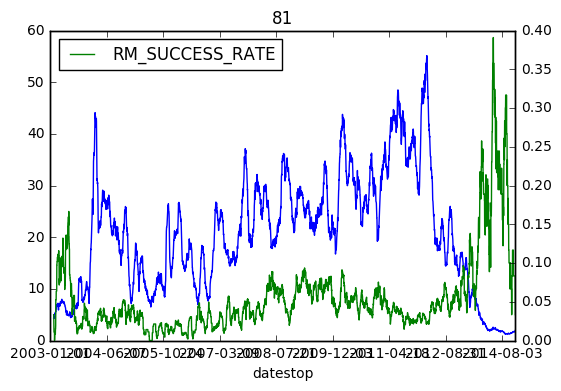

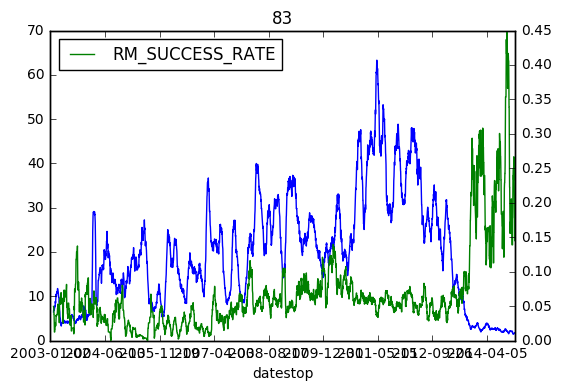

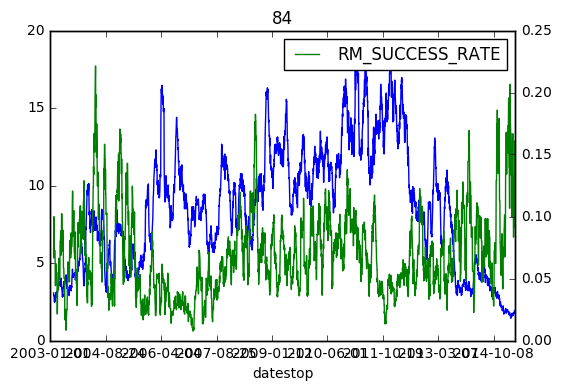

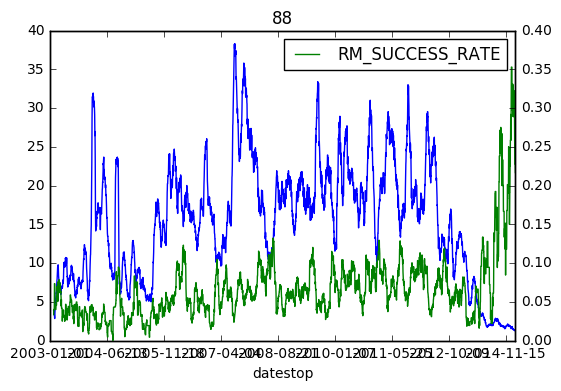

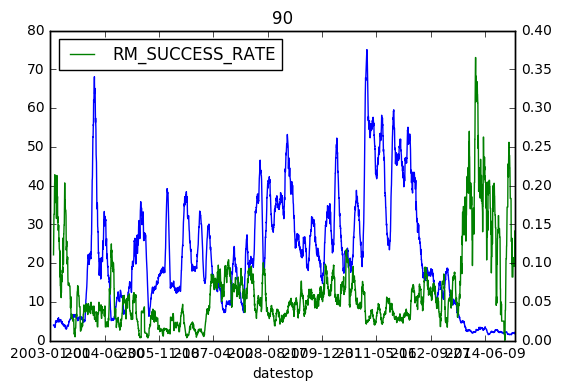

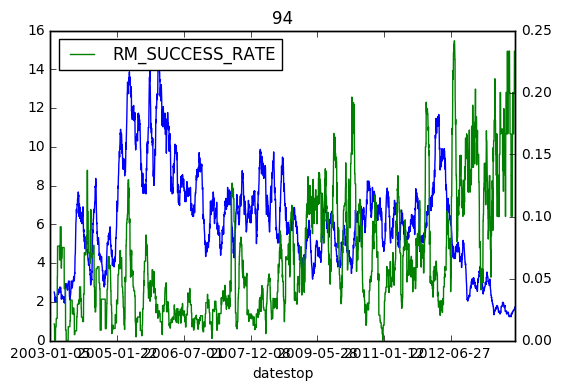

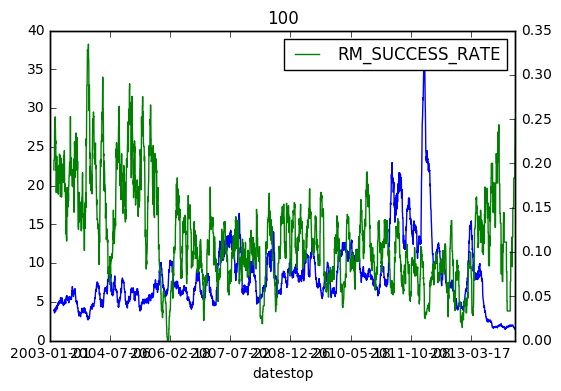

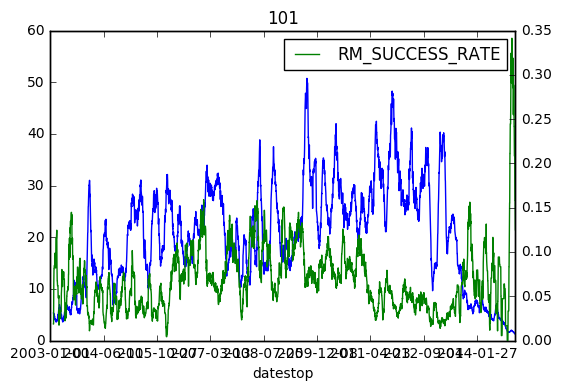

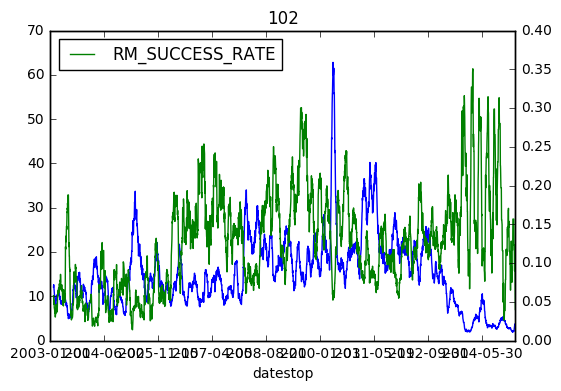

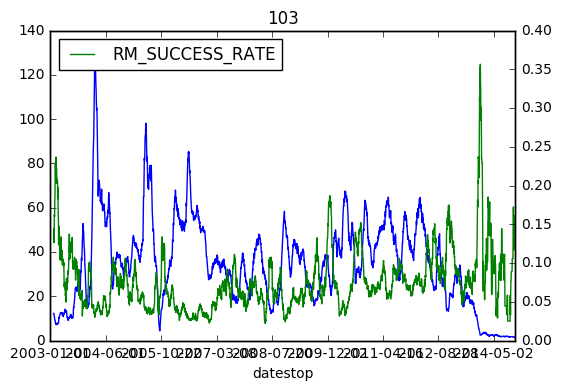

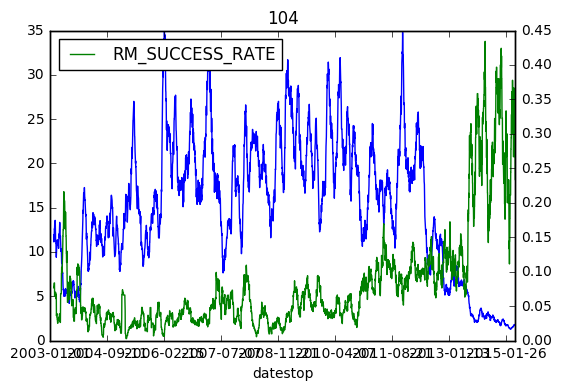

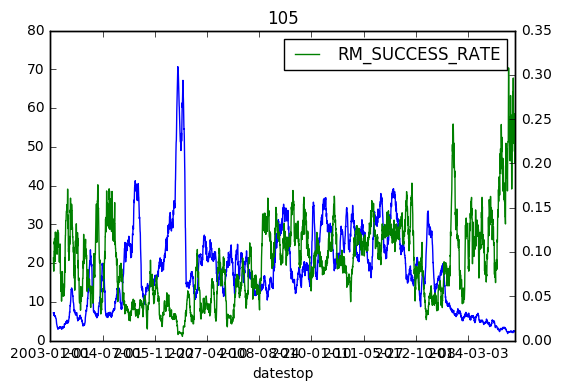

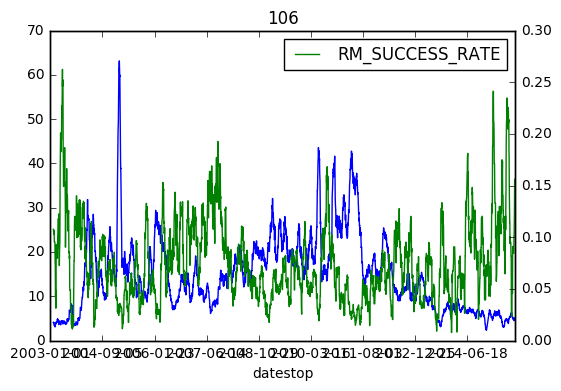

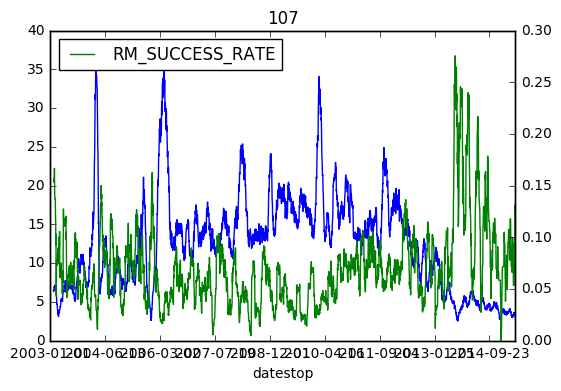

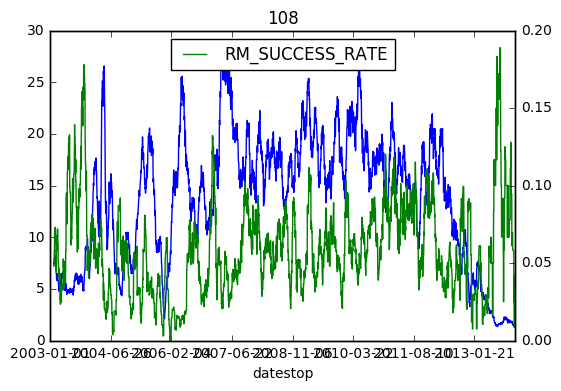

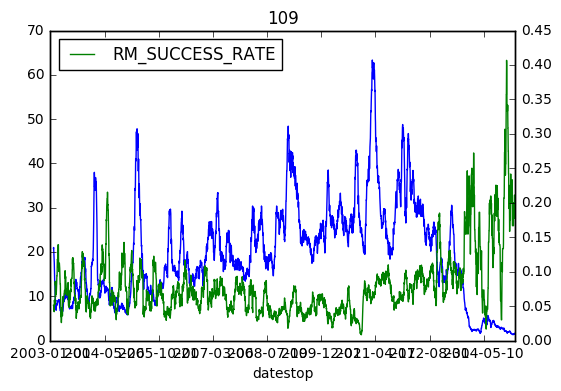

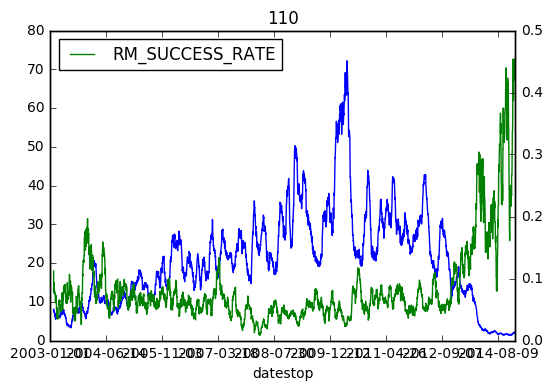

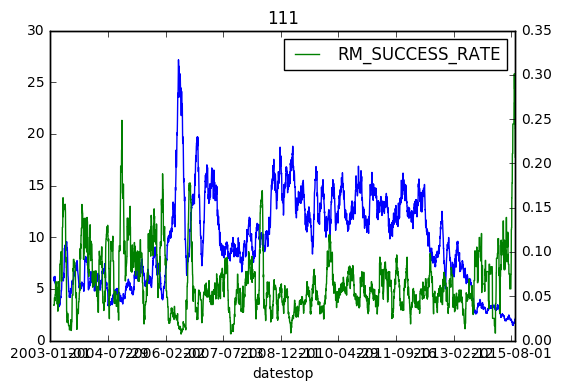

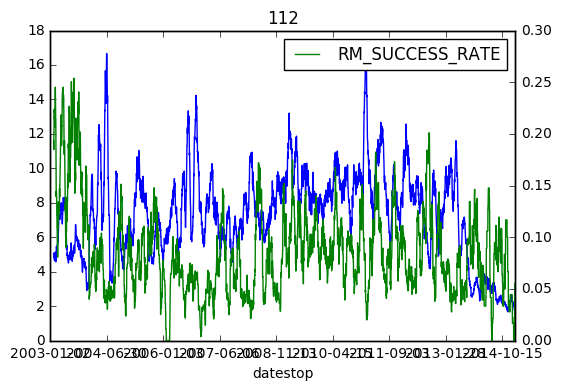

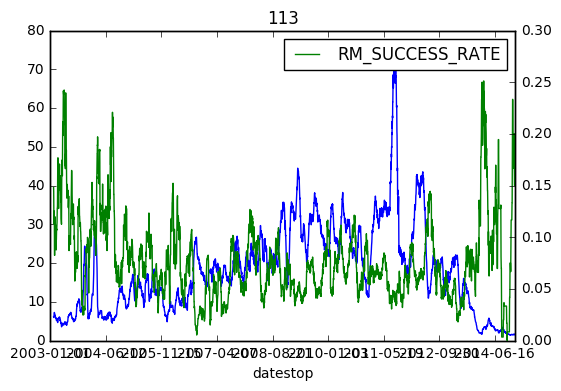

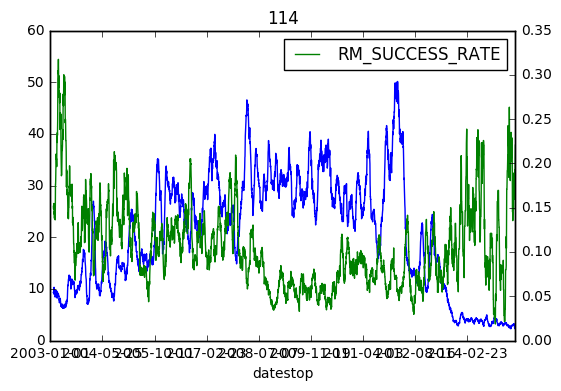

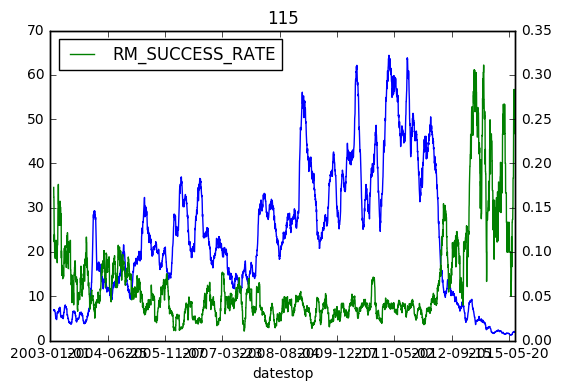

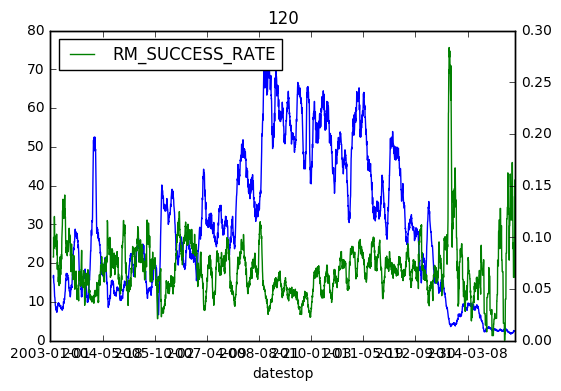

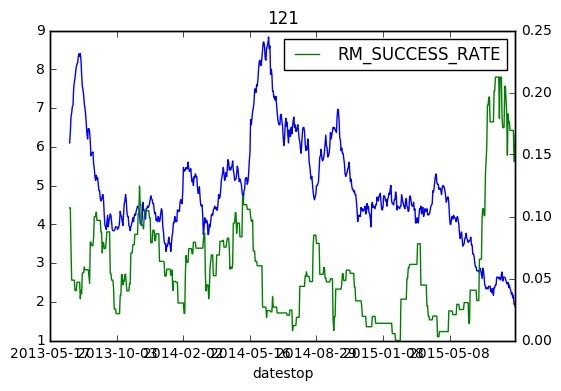

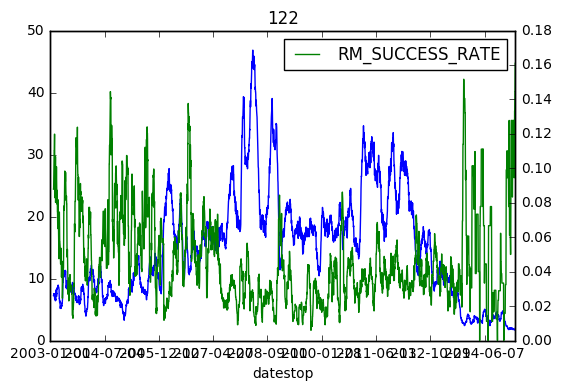

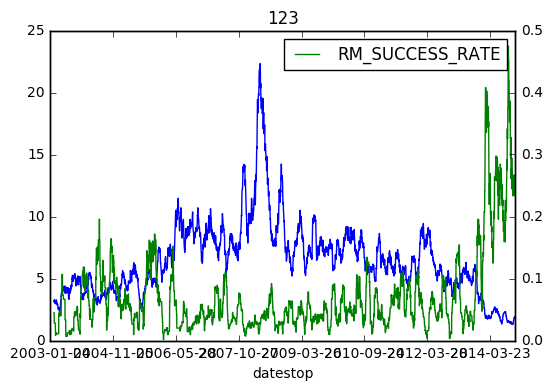

In [148]:
for i in [date_df, race_date_df, pct_date_df]:#, pct_df, race_df, race_pct_df]:
    i.reset_index(inplace=True)
    cols = list(i.columns)
    cols[-2]='False'
    cols[-1]='True'
    i.columns = cols
    i['COUNT'] = i['True'] + i['False']
    i['SUCCESS_RATE'] = i['True'] / i['COUNT']
    
    
    i.index = i.datestop
    try:            
        for j in list(set(i['race'])):
            temp = i[i['race'] == j]
            temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
            temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
            print j
            print temp.loc[:,['COUNT', 'SUCCESS_RATE']].corr()

            plt.figure(); temp['RM_COUNT'].plot(); temp['RM_SUCCESS_RATE'].plot(secondary_y=True);plt.title(j); plt.legend(loc='best')
    except Exception as e:
        try:
            for j in list(set(i['pct'])):
                temp = i[i['pct'] == j]
                temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
                temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
                plt.figure(); temp['RM_COUNT'].plot(); temp['RM_SUCCESS_RATE'].plot(secondary_y=True);plt.title(j); plt.legend(loc='best')
        except:
            i['RM_COUNT'] = pd.rolling_mean(i.COUNT, window=30, min_periods=30)
            i['RM_SUCCESS_RATE'] = pd.rolling_mean(i.SUCCESS_RATE, window=30, min_periods=30)

            plt.figure(); i['RM_COUNT'].plot(); i['RM_SUCCESS_RATE'].plot(secondary_y=True); plt.title(str(list(i.columns))); plt.legend(loc='best')


In [305]:
threshold_SR_A = [date_df['SUCCESS_RATE'].mean() + date_df['SUCCESS_RATE'].std()] 
threshold_SR_B = [date_df['SUCCESS_RATE'].mean() - date_df['SUCCESS_RATE'].std()]

threshold_CNT_B = [date_df['COUNT'].mean() -  date_df['COUNT'].std()] 
threshold_CNT_A = [date_df['COUNT'].mean() +  date_df['COUNT'].std()] 

print ("1-sigma threshold SUCCESS_RATE {:.2f}".format(*threshold_SR_A))
print ("1-sigma threshold COUNT {:.2f}".format(*threshold_CNT_A))
# print ("earliest datapoint", min(date_df.index))

1-sigma threshold SUCCESS_RATE 0.13
1-sigma threshold COUNT 1745.51


In [309]:
date_df['COUNT'].mean()

1063.8439342881213

In [292]:
date_df[['RM_COUNT', 'RM_SUCCESS_RATE']].corr()
import scipy.stats  as stats
stats.pearsonr([1, 2, 3], [4, 3, 7])
stats.pearsonr(date_df['RM_COUNT'].dropna(), date_df['RM_SUCCESS_RATE'].dropna())

(-0.75237194794174134, 0.0)

In [368]:
pd.to_datetime(date_df['datestop'])[0]

Timestamp('2003-01-01 00:00:00')

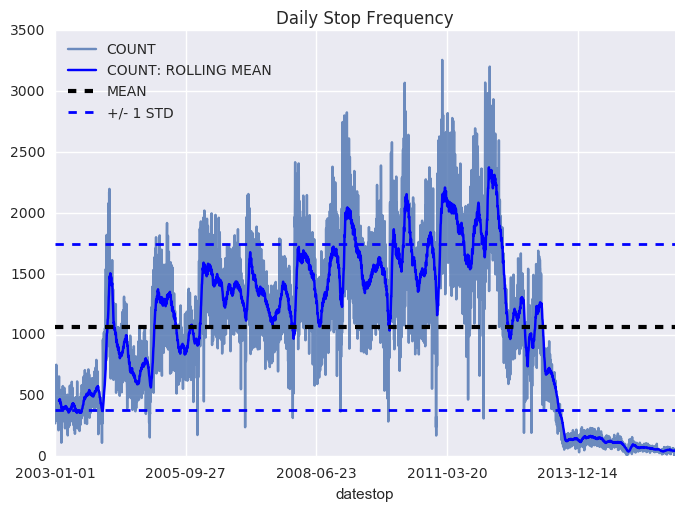

In [320]:
import seaborn
plt.figure();  
ax = date_df['COUNT'].plot(alpha=0.8, label='COUNT'); date_df['RM_COUNT'].plot(color='b', label='COUNT: ROLLING MEAN'); plt.legend(loc='best'); 
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [date_df['COUNT'].mean(), date_df['COUNT'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_A, threshold_CNT_A], ls='--', color="b", lw=2, label='+/- 1 STD')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_B, threshold_CNT_B], ls='--', color="b", lw=2)

# ax2 = date_df['SUCCESS_RATE'].plot(color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(color='r', secondary_y=True)
# ax2.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR, threshold_SR], ls='--', color='IndianRed',  lw=3, label='blah')

#plt.plot([min(date_df.index), max(date_df.index)], [threshold_SR, threshold_SR])
plt.title('Daily Stop Frequency'); plt.legend(loc='best')


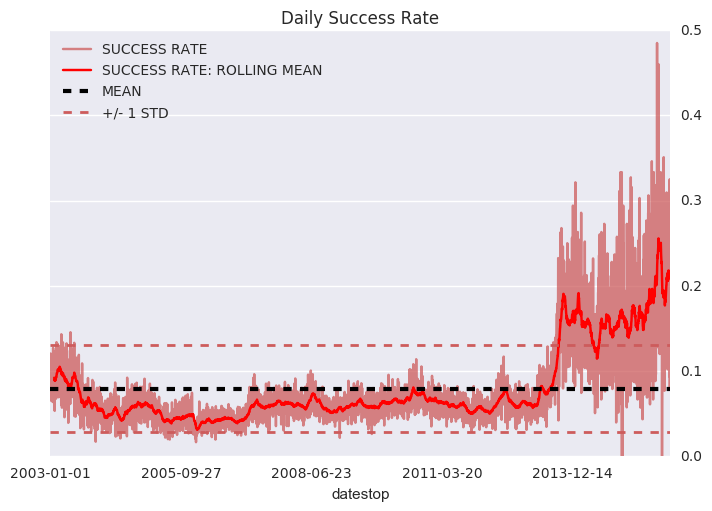

In [357]:
plt.figure(); 

ax2 = date_df['SUCCESS_RATE'].plot(label='SUCCESS RATE', color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(label='SUCCESS RATE: ROLLING MEAN', color='r', secondary_y=True)


ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [date_df['SUCCESS_RATE'].mean(), date_df['SUCCESS_RATE'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_A, threshold_SR_A], ls='--', color="IndianRed", lw=2, label='+/- 1 STD')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_B, threshold_SR_B], ls='--', color='IndianRed', lw=2)
# threshold_SR_2A = date_df['SUCCESS_RATE'].mean() + 2 * date_df['SUCCESS_RATE'].std()
# ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_2A, threshold_SR_2A], ls='--', color='IndianRed', lw=3)
plt.legend(loc='best'); plt.title('Daily Success Rate')

In [401]:
date_df['YEAR'] = pd.to_datetime(date_df.datestop).map(lambda x: x.year)
date_df['MONTH'] = pd.to_datetime(date_df.datestop).map(lambda x: x.month)

# date_df.loc[(date_df.COUNT>threshold_CNT_B)].groupby(pd.to_datetime(date_df.datestop).map(lambda x: x.year))
date_df.loc[(date_df.COUNT<threshold_CNT_B)][['YEAR', 'MONTH', 'COUNT']].groupby(['YEAR']).count()#.to_csv('count.csv')

MONTH  COUNT
YEAR              
2003    114    114
2004     10     10
2005      1      1
2006      1      1
2007      2      2
2008      1      1
2009      1      1
2010      3      3
2011      1      1
2012      3      3
2013    172    172
2014    365    365
2015    365    365

In [402]:
date_df.loc[(date_df.COUNT<threshold_CNT_B)][['YEAR', 'MONTH', 'COUNT']].groupby(['YEAR', 'MONTH']).count()#.to_csv('count.csv')

COUNT
YEAR MONTH       
2003 1          9
     2         12
     3         15
     4         12
     5         10
     6         18
     7         10
     8          8
     9          4
     10         1
     11         1
     12        14
2004 8          1
     9          2
     11         1
     12         6
2005 12         1
2006 12         1
2007 12         2
2008 12         1
2009 12         1
2010 12         3
2011 12         1
2012 10         1
     12         2
2013 3          1
     6          1
     7         17
     8         31
     9         30
     10        31
     11        30
     12        31
2014 1         31
     2         28
     3         31
     4         30
     5         31
     6         30
     7         31
     8         31
     9         30
     10        31
     11        30
     12        31
2015 1         31
     2         28
     3         31
     4         30
     5         31
     6         30
     7         31
     8         31
     9         30
     10        31
     11        30
     12        31

In [399]:
date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A)][['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR']).count()#.to_csv('success_rate.csv')

MONTH  SUCCESS_RATE
YEAR                     
2003      7             7
2013    115           115
2014    235           235
2015    276           276

In [431]:
date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A)][['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')

SUCCESS_RATE
YEAR MONTH              
2003 2                 2
     3                 1
     4                 1
     5                 1
     6                 1
     7                 1
2013 7                 1
     8                17
     9                28
     10               24
     11               23
     12               22
2014 1                25
     2                20
     3                28
     4                18
     5                11
     6                15
     7                20
     8                21
     9                17
     10               19
     11               19
     12               22
2015 1                21
     2                17
     3                20
     4                20
     5                22
     6                19
     7                24
     8                28
     9                28
     10               24
     11               27
     12               26

In [404]:
print ("mean success rate by day {:.3f}".format(date_df['SUCCESS_RATE'].mean()*100))
print ("stdev success rate by day {:.3f}\n".format(date_df['SUCCESS_RATE'].std()*100))

print ("mean count by day {:.3f}".format(date_df['COUNT'].mean()))
print ("stdev count by day {:.3f}".format(date_df['COUNT'].std()))

mean success rate by day 7.953
stdev success rate by day 5.135

mean count by day 1063.844
stdev count by day 681.669


In [405]:
date_df['SUCCESS_RATE'].mean()*100+date_df['SUCCESS_RATE'].std()*100

13.088319747712255

In [413]:
import scipy.stats as stats
sample1 = date_df[date_df['datestop'] >= '2013-08-12']['COUNT']
sample2 = date_df[date_df['datestop'] < '2013-08-12']['COUNT']
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print t_stat,p_val


95.4246701173 0.0


In [419]:
# date_df[date_df['datestop'] >= '2013-08-12']['SUCCESS_RATE']
mean(date_df[date_df['datestop'] > '2013-08-12']['SUCCESS_RATE'])

0.16737260212915622

In [442]:
print len(date_df.loc[(date_df.datestop>='2013-08-12')])

print len(date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A) & (date_df.datestop>='2013-08-12')])#[['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')
print len(date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_2A) & (date_df.datestop>='2013-08-12')])

872
621
314


In [426]:
621./872

0.7121559633027523

In [427]:
314./872

0.36009174311926606

In [428]:
print len(date_df.loc[(date_df.datestop<'2013-08-12')])
print len(date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A) & (date_df.datestop<'2013-08-12')])#[['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')
print len(date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_2A) & (date_df.datestop<'2013-08-12')])

3876
12
0


0.0030959752321981426

In [432]:
date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A)][['YEAR', 'MONTH', 'SUCCESS_RATE']]

YEAR  MONTH  SUCCESS_RATE
datestop                             
2003-02-17  2003      2      0.133929
2003-02-26  2003      2      0.131846
2003-03-26  2003      3      0.143216
2003-04-07  2003      4      0.133721
2003-05-05  2003      5      0.132492
2003-06-04  2003      6      0.145570
2003-07-03  2003      7      0.133166
2013-07-18  2013      7      0.133705
2013-08-01  2013      8      0.137681
2013-08-02  2013      8      0.139286
2013-08-08  2013      8      0.132353
2013-08-11  2013      8      0.142276
2013-08-13  2013      8      0.144509
2013-08-14  2013      8      0.167464
2013-08-16  2013      8      0.165829
2013-08-17  2013      8      0.179012
2013-08-19  2013      8      0.152381
2013-08-20  2013      8      0.155689
2013-08-22  2013      8      0.132597
2013-08-23  2013      8      0.174194
2013-08-24  2013      8      0.232558
2013-08-25  2013      8      0.225000
2013-08-27  2013      8      0.137405
2013-08-29  2013      8      0.209790
2013-08-30  2013      8      0.142857
2013-09-01  2013      9      0.135135
2013-09-02  2013      9      0.163636
2013-09-03  2013      9      0.134454
2013-09-04  2013      9      0.213333
2013-09-05  2013      9      0.198718
...          ...    ...           ...
2015-11-26  2015     11      0.222222
2015-11-27  2015     11      0.254237
2015-11-29  2015     11      0.228571
2015-11-30  2015     11      0.212766
2015-12-01  2015     12      0.187500
2015-12-02  2015     12      0.309524
2015-12-03  2015     12      0.300000
2015-12-04  2015     12      0.222222
2015-12-05  2015     12      0.266667
2015-12-06  2015     12      0.183673
2015-12-07  2015     12      0.276596
2015-12-08  2015     12      0.200000
2015-12-09  2015     12      0.219512
2015-12-11  2015     12      0.203704
2015-12-12  2015     12      0.240741
2015-12-13  2015     12      0.194030
2015-12-14  2015     12      0.261905
2015-12-16  2015     12      0.300000
2015-12-17  2015     12      0.215385
2015-12-18  2015     12      0.156250
2015-12-19  2015     12      0.183673
2015-12-20  2015     12      0.194444
2015-12-21  2015     12      0.218750
2015-12-22  2015     12      0.200000
2015-12-24  2015     12      0.230769
2015-12-25  2015     12      0.285714
2015-12-26  2015     12      0.325000
2015-12-28  2015     12      0.208333
2015-12-29  2015     12      0.131579
2015-12-30  2015     12      0.206897

[633 rows x 3 columns]

In [437]:
print len(date_df.loc[(date_df.datestop<'2013-08-12')])
print len(date_df.loc[(date_df.COUNT<threshold_CNT_B) & (date_df.datestop<'2013-08-12')])#[['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')
print len(date_df.loc[(date_df.COUNT<threshold_CNT_B) & (date_df.datestop<'2013-08-12')])

3876
167
167
